In [2]:
import pandas as pd
import numpy as np
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,  \
                            roc_curve, precision_recall_curve, auc, confusion_matrix


from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

sns.set_style('darkgrid', {'grid.color': '0.1'})

# 1. Первичный взгляд на данные и предобработка

In [3]:
df = pd.read_excel('df_zaim.xlsx')

In [4]:
df.head()

,al_ContractNumber,al_amount,al_issue_M,psp_issue_rgn,sex,is_client_local,has_snils,zaim_cards,age,responsecode,...,avg_payout_period_pdl,avg_pdl_full_cost,avg_pdl_amount,pdl_delay5_avg,pdl_delay30_avg,pdl_delay60_avg,pdl_delay90_avg,pdl_delay_more_avg,res_npl_15,is_test
0,882-001-17,3000,1,30,1,0,0,0,2,1,...,1,1,0.000000,0,0,0,0,0,0,0
1,1776-001-17,5000,1,55,1,0,1,0,2,1,...,0,1,50459.705882,0,0,0,0,0,1,0
2,2234-001-17,5000,1,32,1,0,1,0,3,1,...,0,1,2500.000000,0,0,0,0,0,0,0
3,2649-001-17,5000,1,77,2,1,1,0,3,0,...,1,1,0.000000,0,0,0,0,0,1,0
4,2320-001-17,3000,1,77,2,1,1,0,3,0,...,1,1,0.000000,0,0,0,0,0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9986 entries, 0 to 9985
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   al_ContractNumber             9986 non-null   object 
 1   al_amount                     9986 non-null   int64  
 2   al_issue_M                    9986 non-null   int64  
 3   psp_issue_rgn                 9986 non-null   int64  
 4   sex                           9986 non-null   int64  
 5   is_client_local               9986 non-null   int64  
 6   has_snils                     9986 non-null   int64  
 7   zaim_cards                    9986 non-null   int64  
 8   age                           9986 non-null   int64  
 9   responsecode                  9986 non-null   int64  
 10  was_garant                    9986 non-null   int64  
 11  is_pboul                      9986 non-null   int64  
 12  has_foreign_currency_credits  9986 non-null   int64  
 13  cou

Видим:
- пропуски отсутствуют
- столбец al_ContractNumber для нас ценности не несет, можно удалить
- многие признаки являются бинарными (1 или 0)).
- у столбца sex есть смысл заменить значения с 1-2 на 0-1
- есть признаки с числовым типом данных но это по факту категориальные признаки:
    - al_issue_M – месяц выдачи одобренного кредита
    - psp_issue_rgn – регион выдачи паспорта клиента
    - responsecode – код ответа от БКИ по наличию данных о кредитах у клиента на момент заявки. 
- responsecode - есть одно значение "98", которое сильно отличается от остальных - 0/1/3. Cохраним эту информацию но заменим "98" на свободное число "2", потому что основные значения признака - 0/1 и  большое значение "98" может внести сильную погрешность при анализе корреляций с целевым признаком

## 1.1 Удаляем номер контракта. Заменяем значения в sex. Заменяем "98" на "2" в responsecode

In [6]:
df.drop(columns= ['al_ContractNumber'], inplace = True)
df['sex'].replace({1:0, 2:1}, inplace = True)
df['responsecode'].replace({98:2}, inplace = True)

# 2. Исследовательский анализ данных
Определим 
- категориальные признаки (не бинарные)
- бинарные признаки
- числовые признаки \
Для этого посмотрим на число уникальных значений в признаках

In [7]:
df_uniq = df.apply('nunique', axis = 0).sort_values(ascending = False)
pd.options.display.max_rows = 50
display(df_uniq)
pd.options.display.max_rows = 10

avg_pdl_amount                  537
psp_issue_rgn                    86
pdl_closed_tot                   42
pdl_delay_more_cnt               21
potreb_closed_tot                20
potreb_other_states_tot          15
pdl_delay_more_avg               14
pdl_active_tot                   14
pdl_other_states_tot             14
al_issue_M                       12
potreb_active_tot                11
has_resold_credits                6
was_garant                        5
has_foreign_currency_credits      4
responsecode                      4
age                               3
al_amount                         3
is_pboul                          2
court_counts                      2
cred_line_state                   2
zaim_cards                        2
official_count                    2
has_snils                         2
is_client_local                   2
sex                               2
is_test                           2
potreb_tot                        2
res_npl_15                  

In [8]:
# Выделяем категориальные НЕ бинарные признаки 
cat_features = ['psp_issue_rgn', 'al_issue_M', 'responsecode']

# Выделяем бинарные признаки
bin_features = list(df_uniq[df_uniq == 2].index)

# Выделяем числовые признаки
num_features = list(df_uniq[df_uniq > 2].index)
# убираем из числовых признаков 3 признака, которые по условию задачи являются категориальными
num_features = list(set(num_features) - set(cat_features))

## 2.2 Посмотрим на корреляцию признаков с целевым признаком

In [9]:
# создаем матрицу корреляций.
df_corr = df.corr()

# Выводим корреляцию по целевому признаку
df_corr.sort_values('res_npl_15')['res_npl_15']

responsecode      -0.455824
potreb_tot        -0.314650
pdl_tot           -0.174444
pdl_prolong_cnt   -0.174444
al_amount         -0.124841
                     ...   
sex                0.080872
age                0.085226
is_client_local    0.090612
psp_issue_rgn      0.105302
res_npl_15         1.000000
Name: res_npl_15, Length: 41, dtype: float64

Видим:  
- Очень хорошая корреляция с признаком responsecode (45%) и относительно хорошая корреляция (10%) с признаком psp_issue_rgn, которые по факту являются категориальными

Рассмотрим подробнее признаки с корреляцией выше 0.08

In [10]:
good_features = list(df_corr[abs(df_corr['res_npl_15']) > 0.08]['res_npl_15'].index)
good_features

['al_amount',
 'psp_issue_rgn',
 'sex',
 'is_client_local',
 'age',
 'responsecode',
 'has_resold_credits',
 'potreb_tot',
 'potreb_closed_tot',
 'pdl_tot',
 'pdl_delay30_cnt',
 'pdl_delay90_cnt',
 'pdl_prolong_cnt',
 'avg_pdl_full_cost',
 'res_npl_15']

Гистограммы признаков с корреляцией >0.08 и разбивкой по целевому признаку


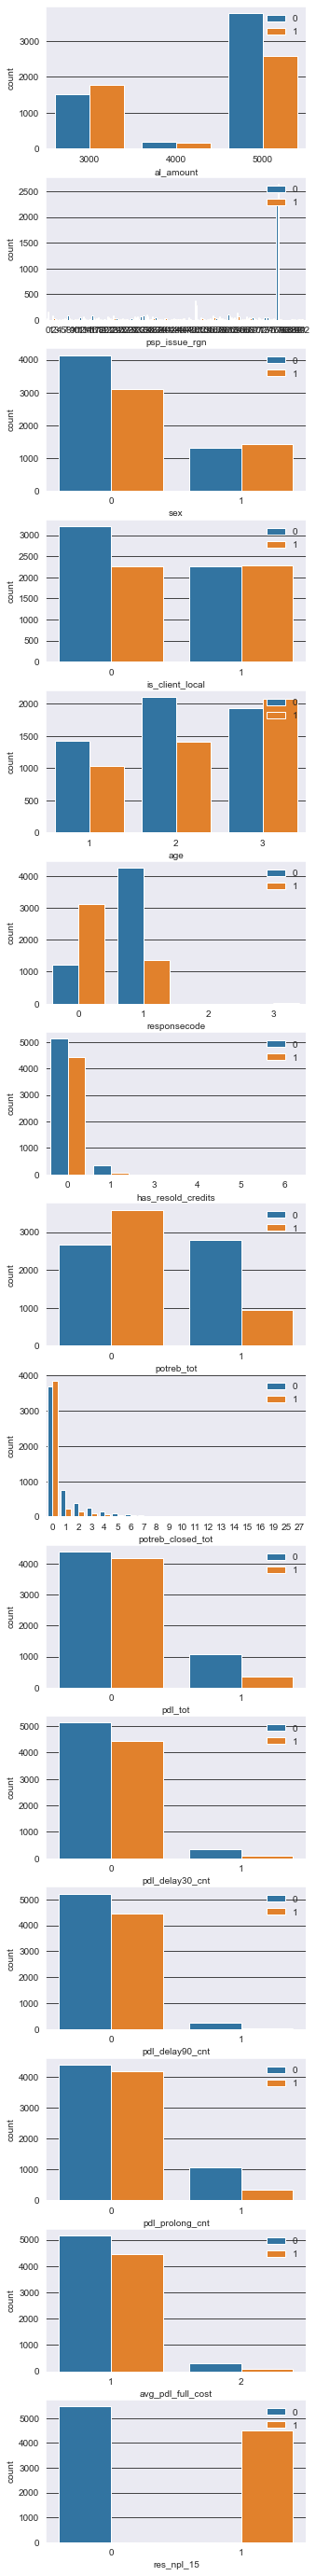

In [11]:
# строим гистограммы
fig, ax = plt.subplots(len(good_features),1, figsize=(5,50))
i = 0
print('Гистограммы признаков с корреляцией >0.08 и разбивкой по целевому признаку')
for col in good_features:
  #if col != 'psp_issue_rgn':
  sns.countplot(x = df[col], hue = df['res_npl_15'], ax=ax[i])
  ax[i].legend(loc='upper right', frameon=False)
  i += 1

Видим: 
1. Зависимость между выбранными признаками и целевым признаком визуально прослеживается. \
2. У Responsecode почти все значения 0/1.  Они и вносят вклад в корреляцию. \
3. Еще у многих признаков есть очень редкие значения. \
4. Получилась не наглядная гистограмма для региона выдачи psp_issue_region.  Для него построим ниже отдельные гистограммы вместе с другими НЕ бинарными категориальными признаками  

## 2.3 Посмотрим на категориальный НЕ бинарный признак 'psp_issue_rgn'

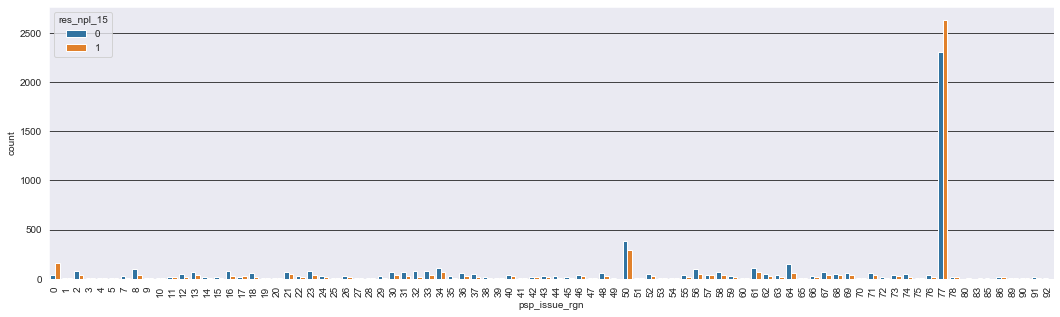

In [12]:
plt.figure(figsize = (18,5))
sns.countplot(data=df, x = 'psp_issue_rgn', hue = 'res_npl_15')
plt.xticks(rotation = 90)
plt.show()

Посмотрим на соотношение значений целевого признака по каждому региону

In [13]:
# Создаем сводную таблицу
df_group1 = df.groupby('psp_issue_rgn').agg({'res_npl_15': ['count','mean']}).reset_index()
df_group1.columns = ['psp_issue_rgn', 'credits_count', 'res_npl_15_mean']

# Выводим сводную таблицу, с которой
# - номер региона / кол-во кредитов с данного региона / среднее значение целевого признака
pd.options.display.max_rows = 100
display(df_group1.sort_values('res_npl_15_mean'))
pd.options.display.max_rows = 10

,psp_issue_rgn,credits_count,res_npl_15_mean
85,92,1,0.000000
48,49,1,0.000000
80,85,1,0.000000
19,20,9,0.111111
8,9,8,0.125000
6,7,32,0.156250
4,4,6,0.166667
31,32,93,0.193548
17,18,71,0.197183
52,53,13,0.230769


Видим: \
1. Сам номер региона как количественный признак не влияет на целевой признак, это соответствует здравому смыслу.  \
2. Достаточное количество данных есть только для московского региона (4953) и там преобладает возврат кредита в указанный срок (53%) . Для всех остальных регионов очень мало данных если брать их в отдельности. В целом мы видим что в них преобладает НЕ ВОЗВРАТ кредита в указанный срок.
3. Есть регион с индексом 0. Похоже ошибка. У него очень высокий возврат кредита в указанный срок (82% в 195 случаях).
4. С учетом всего вышеперечисленного можем создать новый признак, который будет полезен для нашей модели:   1 - Москва либо нулевой регион, 0 - все остальные

In [14]:
df['psp_issue_rgn_type'] = df['psp_issue_rgn'].apply(lambda x: (x in [77,0])*1)
df['psp_issue_rgn_type']

0       0
1       0
2       0
3       1
4       1
       ..
9981    1
9982    1
9983    1
9984    0
9985    0
Name: psp_issue_rgn_type, Length: 9986, dtype: int64

## 2.4 Посмотрим на категориальный НЕ бинарный признак 'al_issue_M'

Диаграммы countplot признака "al_issue_M" с разбивкой по целевому признаку


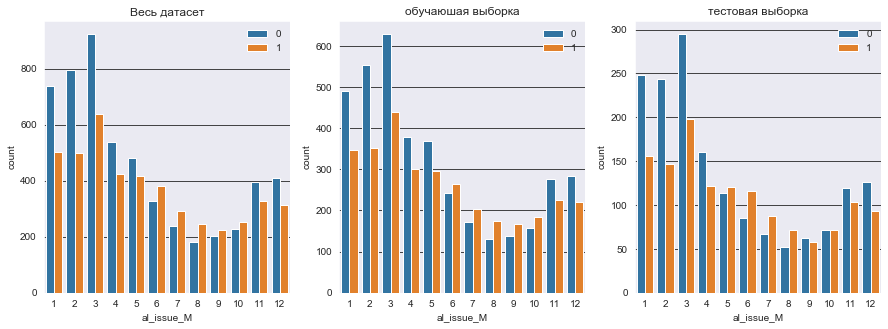

In [15]:
# Рассмотрим отдельно весь датасет, затем только обучающую, затем только тестовую.
fig, ax = plt.subplots(1,3, figsize=(15,5))
i = 0
filters = [[0,1], [0], [1]]
titles = ['Весь датасет', 'обучаюшая выборка', 'тестовая выборка']
print('Диаграммы countplot признака "al_issue_M" с разбивкой по целевому признаку')
for filt in filters:
    sns.countplot(x = df[df['is_test'].isin(filt)]['al_issue_M'], hue = df['res_npl_15'], ax=ax[i])
    ax[i].legend(loc='upper right', frameon=False)
    ax[i].set_title(titles[i])
    i += 1

Наблюдаем сезонность по целевому признаку (картина одинакова и для обучающей и для тестовой выборки). \
Летом люди берут кредиты реже, но возвращают их лучше, чем зимой. \
По данной информации мы можем задать количественный признак, который будет показывать соотношение по целевом признаку в каждо месяце.
!!! Но для его вычисления мы будем брать данные ТОЛЬКО из тестовой выборки, т.к. иначе у нас будет эффект "подглядывания". \
Создадим данный признак

In [16]:
# Создаем сводную таблицу по данным из обучающей выборки
df_group2 = df[df['is_test'] == 0].groupby('al_issue_M').agg({'res_npl_15': ['count','mean']}).reset_index()
df_group2.columns = ['al_issue_M', 'credits_count', 'res_npl_15_mean']

pd.options.display.max_rows = 20
display(df_group2)
pd.options.display.max_rows = 10
# В таблице ниже содержатся:
# номер месяца / количество взтых кредитов / среднее значение целевого признака
# !!! Данные только по ОБУЧАЮЩЕЙ ВЫБОРКЕ

,al_issue_M,credits_count,res_npl_15_mean
0,1,839,0.414779
1,2,904,0.388274
2,3,1069,0.411600
3,4,680,0.444118
4,5,665,0.446617
5,6,506,0.521739
6,7,376,0.542553
7,8,305,0.570492
8,9,306,0.545752
9,10,340,0.538235


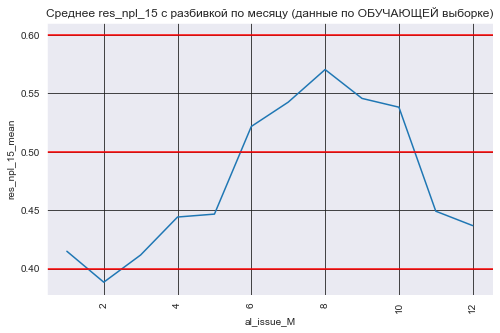

In [17]:
# Для наглядности можем визуализировать нашу сезонность 
plt.figure(figsize = (8,5))
sns.lineplot(data=df_group2, x = 'al_issue_M', y = 'res_npl_15_mean')
plt.axhline(y = 0.6, color='r')
plt.axhline(y = 0.5, color='r')
plt.axhline(y = 0.4, color='r')
plt.xticks(rotation = 90)
plt.title('Среднее res_npl_15 с разбивкой по месяцу (данные по ОБУЧАЮЩЕЙ выборке)')
plt.show()


Итого - наш новый признак будет иметь значения из столбца res_npl_15_mean (они же выведены на графике выше) для соответствующего номера месяца

In [18]:
# наконец создаем наш признак
df['res_ratio_by_month'] = df['al_issue_M'].replace(
    dict(zip(df_group2['al_issue_M'].values, df_group2['res_npl_15_mean'].values)))

## 2.5 Посмотрим на числовые признаки

Диаграммы числовых признаков с разбивкой по целевому признаку


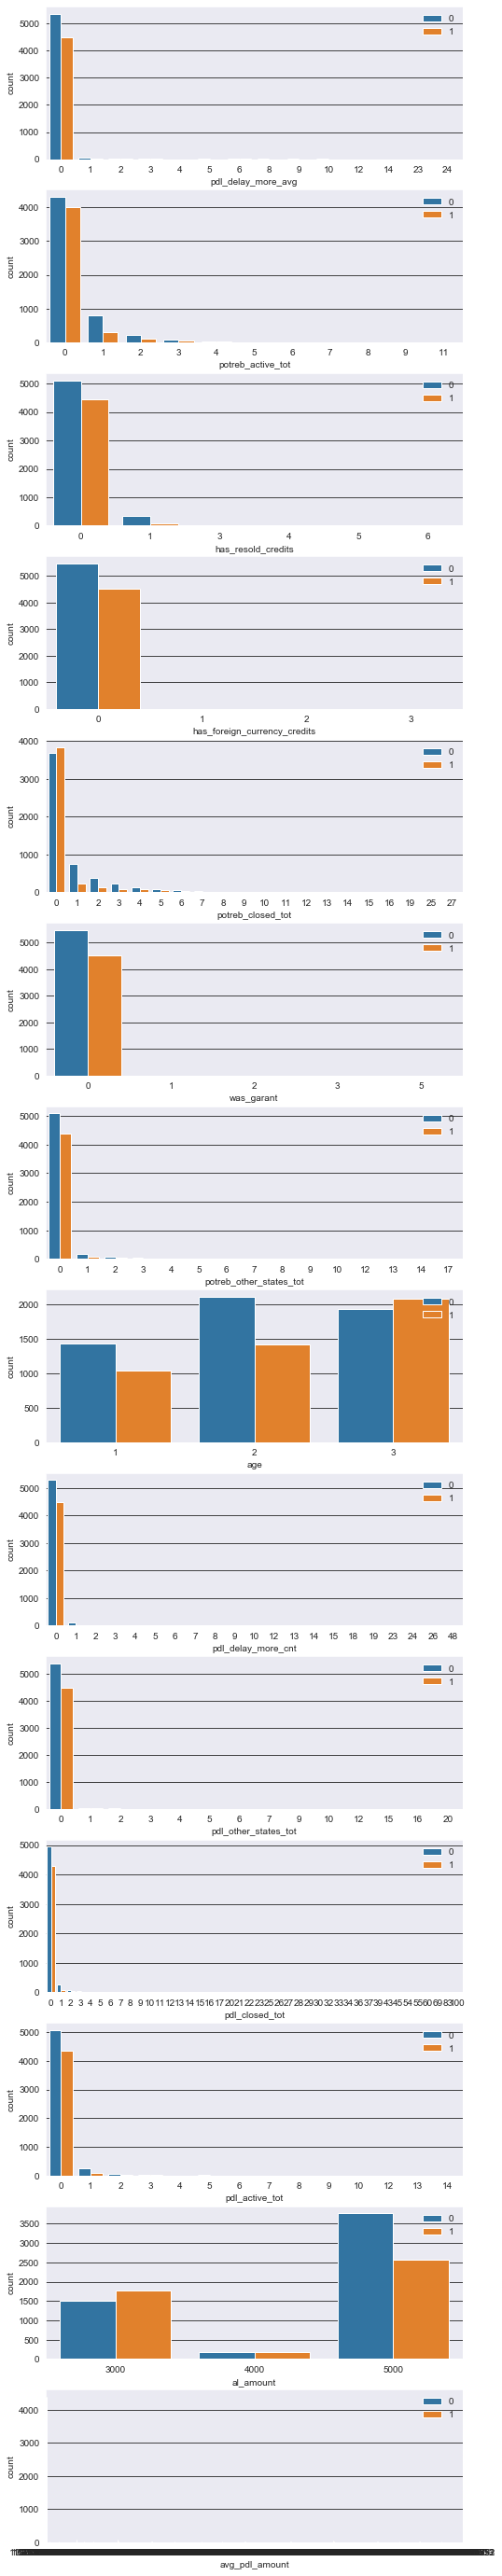

In [19]:
# строим диаграммы
fig, ax = plt.subplots(len(num_features),1, figsize=(8,50))
i = 0
print('Диаграммы числовых признаков с разбивкой по целевому признаку')
for col in num_features:
    sns.countplot(x = df[col], hue = df['res_npl_15'], ax=ax[i])
    ax[i].legend(loc='upper right', frameon=False)
    i += 1

Видим:
- по некоторым признакам видна зависимость с целевым признаком
- Есть признаки, у которых преобладает 1/ 2 значений, а остальные встречаются редко.
- не получилось посмотреть на признаки pdl_closed_tot, avg_pdl_amount. Их рассмотрим отдельно

### 2.5.1 pdl_closed_tot

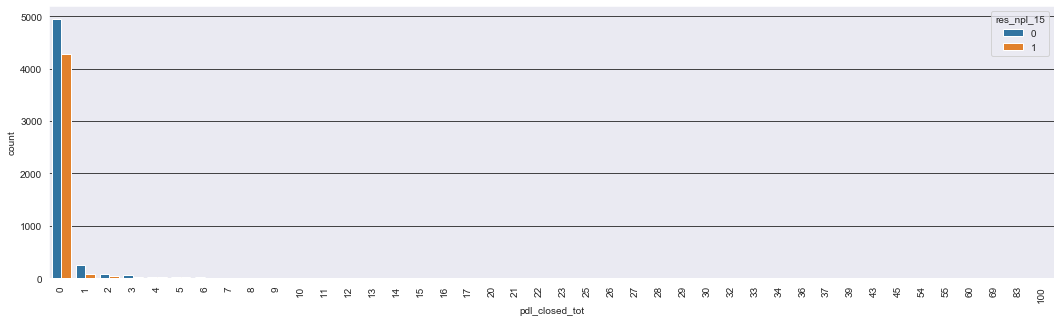

In [20]:
plt.figure(figsize = (18,5))
sns.countplot(data=df, x = 'pdl_closed_tot', hue = 'res_npl_15')
plt.xticks(rotation = 90)
plt.show()

У pdl_closed_tot преобладает значение 0.  Других инсайтов не видно

### 2.5.2 avg_pdl_amount

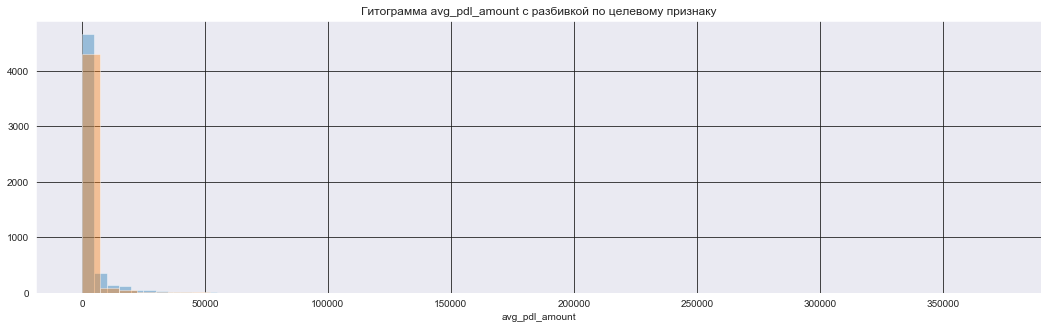

In [21]:
plt.figure(figsize = (18,5))
sns.distplot(df[df['res_npl_15'] == 0]['avg_pdl_amount'], kde = False)
sns.distplot(df[df['res_npl_15'] == 1]['avg_pdl_amount'], kde = False)
plt.title('Гитограмма avg_pdl_amount c разбивкой по целевому признаку')
plt.show()

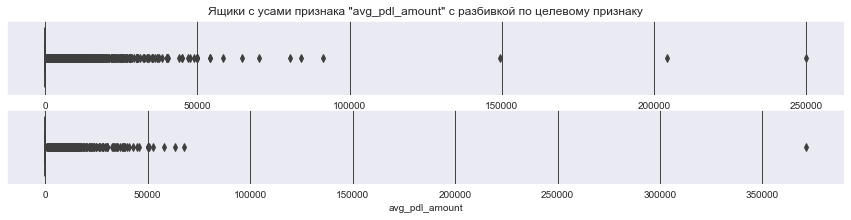

In [22]:
fig, ax = plt.subplots(2,1, figsize=(15,3))
sns.boxplot(df[df['res_npl_15'] == 0]['avg_pdl_amount'],ax = ax[0])
sns.boxplot(df[df['res_npl_15'] == 1]['avg_pdl_amount'],ax = ax[1])
ax[0].set_title('Ящики с усами признака "avg_pdl_amount" с разбивкой по целевому признаку')
plt.show()

Есть клиенты с очень большим долгом

Text(0.5, 1.0, 'Ящики с усами признака "avg_pdl_amount" с разбивкой по принадлежности к обучающей/тестовой выборке')

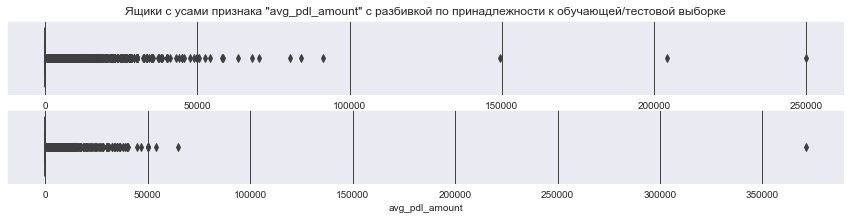

In [23]:
fig, ax = plt.subplots(2,1, figsize=(15,3))
sns.boxplot(df[df['is_test'] == 0]['avg_pdl_amount'],ax = ax[0])
sns.boxplot(df[df['is_test'] == 1]['avg_pdl_amount'],ax = ax[1])
ax[0].set_title('Ящики с усами признака "avg_pdl_amount" с разбивкой по принадлежности к обучающей/тестовой выборке')

Есть клиенты с очень большим долгом

Рассмотрим отдельно случаи, когда есть задолжность на момент обращения и когда отсутствует.  
Создадим для этого новый признак

In [24]:
df['pdl_amount_status'] = (df['avg_pdl_amount'] != 0) * 1

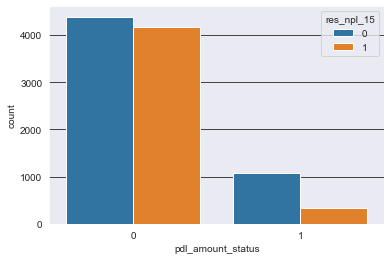

In [25]:
sns.countplot(data=df, x = 'pdl_amount_status', hue = 'res_npl_15')

Видим зависимость между целевым признаком и созданным нами признаком pdl_amount_status.  Этот признак пригодится нам для наших моделей

## 2.6 Корреляционный анализ  
Посмотрим на тепловую карту матрицы корреляций наших признаков

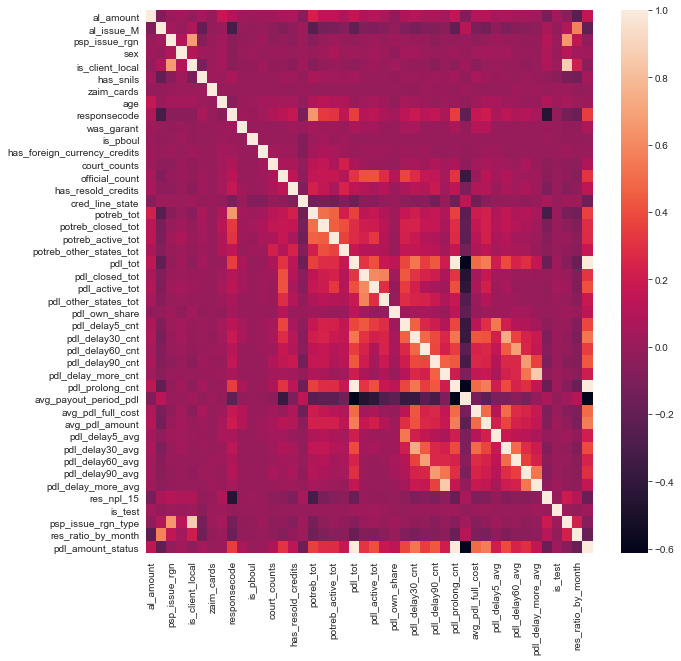

In [26]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr())

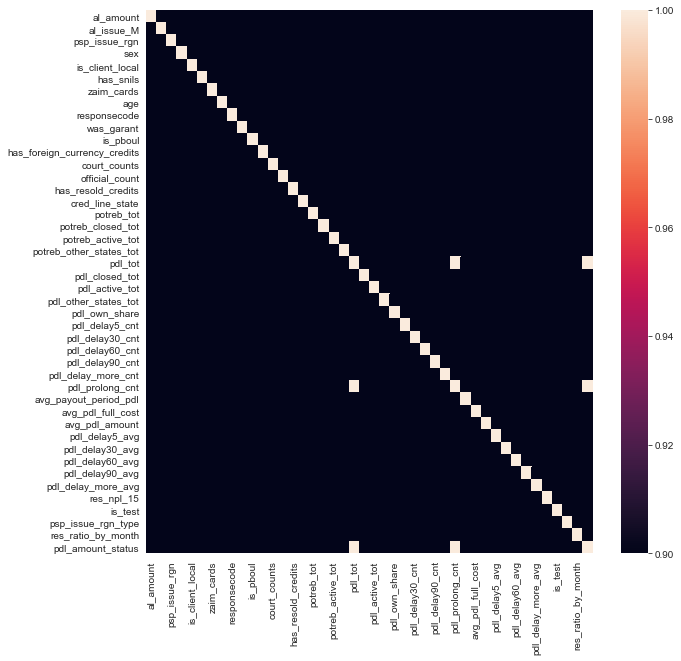

In [27]:
plt.figure(figsize = (10,10))
sns.heatmap(df.corr(), vmin=0.9, vmax=1)

На тепловой карте видим  очень сильную корреляцию между pdl_tot , pdl_prolong_cnt, 'pdl_amount_status' (этот признак мы создали самостоятельно). Проверим точно

In [28]:
df[['pdl_tot','pdl_prolong_cnt', 'pdl_amount_status']].corr()

,pdl_tot,pdl_prolong_cnt,pdl_amount_status
pdl_tot,1.0,1.0,1.0
pdl_prolong_cnt,1.0,1.0,1.0
pdl_amount_status,1.0,1.0,1.0


Да, признаки совпадают на 100%. Это вызывет проблемы у обучающих моделей, стоит оставить только 1 из них. 

# 3. Подготовка данных для ML моделей

1. Разбираемся с responsecode (значение 98)
2. Убираем ненужные признаки согласно корреляционному анализу
3. Еще раз посмотрим на корреляцию признаков с целевым и выделим признаки с ВЫСОКОЙ и НИЗКОЙ корреляцией
4. Посмотрим на признаки со слабой корреляцией. Попробуем удалить из них НЕНУЖНЫЕ
5. Выделяем 
5. Полноценная предобработка числовых и категориальных признаков

## 3.1 Разбираемся с responsecode  
В задаче не уточняется - нужно предсказать вероятности только для тестовой или для обоих выборок.  Поэтому не удаляем строку с единственным значением responsecode.  Будем поноценно предобрабатывать этот признак далее 

In [29]:
# df['responsecode'].value_counts()

In [30]:
# df[df['responsecode'] == 2]

In [31]:
# df.drop(index = 1548, inplace = True)
# df.reset_index(drop = True, inplace=True)

## 3.2 Убираем ненужные признаки

In [32]:
# Ненужные категориальные признаки, на основе которых уже создали собственные полезные признаки + 
# задублированные признаки, которые найдены при корреляционном анализе
df.drop(columns = ['al_issue_M', 'psp_issue_rgn'] + ['pdl_prolong_cnt', 'pdl_amount_status'], inplace = True)

##  3.3 У нас удалились/добавились признаки. Еще раз  посмотрим на корреляцию признаков с целевым и определим самые полезные признаки

In [33]:
# Выводим корреляцию по целевому признаку
pd.options.display.max_rows = 100
df_corr_new = df.corr().sort_values('res_npl_15')['res_npl_15']
display(df_corr_new)
pd.options.display.max_rows = 10

responsecode                   -0.455824
potreb_tot                     -0.314650
pdl_tot                        -0.174444
al_amount                      -0.124841
potreb_closed_tot              -0.107378
pdl_delay30_cnt                -0.099557
has_resold_credits             -0.099072
pdl_delay90_cnt                -0.099070
avg_pdl_full_cost              -0.097829
avg_pdl_amount                 -0.079202
pdl_delay30_avg                -0.077022
pdl_delay90_avg                -0.070262
pdl_delay60_cnt                -0.066793
potreb_active_tot              -0.066279
potreb_other_states_tot        -0.052215
official_count                 -0.044267
pdl_delay60_avg                -0.043524
pdl_delay_more_cnt             -0.038028
pdl_delay5_cnt                 -0.037127
court_counts                   -0.035621
pdl_delay_more_avg             -0.033463
has_snils                      -0.018515
pdl_active_tot                 -0.017140
pdl_delay5_avg                 -0.013707
pdl_other_states

В качестве хороших признаков выберем те, у которых корреляция > 0.09

In [34]:
good_features_new = list(df_corr_new[abs(df_corr_new) > 0.09].index)
good_features_new

['responsecode',
 'potreb_tot',
 'pdl_tot',
 'al_amount',
 'potreb_closed_tot',
 'pdl_delay30_cnt',
 'has_resold_credits',
 'pdl_delay90_cnt',
 'avg_pdl_full_cost',
 'is_client_local',
 'res_ratio_by_month',
 'psp_issue_rgn_type',
 'res_npl_15']

## 3.4  Теперь посмотрим на признаки с низкой корреляцией

In [35]:
bad_features_new = list(set(df.columns) - set(good_features_new))

In [36]:
pd.options.display.max_rows = 50
display(df[bad_features_new].apply('nunique', axis = 0).sort_values(ascending = False))
pd.options.display.max_rows = 10

avg_pdl_amount                  537
pdl_closed_tot                   42
pdl_delay_more_cnt               21
potreb_other_states_tot          15
pdl_delay_more_avg               14
pdl_other_states_tot             14
pdl_active_tot                   14
potreb_active_tot                11
was_garant                        5
has_foreign_currency_credits      4
age                               3
pdl_delay5_cnt                    2
pdl_delay60_cnt                   2
sex                               2
pdl_delay60_avg                   2
avg_payout_period_pdl             2
pdl_own_share                     2
has_snils                         2
pdl_delay30_avg                   2
pdl_delay5_avg                    2
zaim_cards                        2
is_test                           2
cred_line_state                   2
official_count                    2
pdl_delay90_avg                   2
court_counts                      2
is_pboul                          2
dtype: int64

Следующая таблица является слиянием всех признаков из списка bad_features_new , к которым применяется метод value_сounts.  То есть мы можем посмотреть СКОЛЬКО РАЗ ВСТРЕЧАЕТСЯ ТО ИЛИ ИНОЕ ЗНАЧЕНИЕ В КАЖДОМ ПРИЗНАКЕ

In [37]:
list_vc = []
for col in bad_features_new:
    list_vc.append(df[col].value_counts())
df_vc =  pd.concat(list_vc, axis = 1)
pd.options.display.max_columns = 30
display(df_vc)
pd.options.display.max_columns = 10

,potreb_active_tot,pdl_delay60_cnt,has_foreign_currency_credits,sex,pdl_delay60_avg,avg_payout_period_pdl,pdl_own_share,pdl_delay_more_cnt,pdl_active_tot,pdl_delay30_avg,zaim_cards,is_test,pdl_delay_more_avg,is_pboul,official_count,pdl_delay90_avg,court_counts,pdl_delay5_avg,pdl_delay5_cnt,was_garant,age,potreb_other_states_tot,has_snils,pdl_other_states_tot,pdl_closed_tot,cred_line_state,avg_pdl_amount
0.000,8303.0,9789.0,9968.0,7243.0,9891.0,584.0,9956.0,9758.0,9410.0,9743.0,9969.0,6997.0,9876.0,9985.0,9772.0,9847.0,9885.0,9916.0,9752.0,9971.0,NaN,9471.0,8333.0,9863.0,9221.0,NaN,8574.0
1.000,1104.0,197.0,14.0,2743.0,95.0,9402.0,30.0,136.0,362.0,243.0,17.0,2989.0,66.0,NaN,214.0,139.0,101.0,70.0,234.0,8.0,2468.0,253.0,1653.0,62.0,346.0,172.0,NaN
2.000,343.0,NaN,3.0,NaN,NaN,NaN,NaN,23.0,89.0,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3514.0,115.0,NaN,28.0,118.0,9814.0,NaN
3.000,140.0,NaN,1.0,NaN,NaN,NaN,NaN,15.0,37.0,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4004.0,68.0,NaN,12.0,73.0,NaN,NaN
4.000,47.0,NaN,NaN,NaN,NaN,NaN,NaN,6.0,16.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,NaN,3.0,47.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91329.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
149523.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
204414.685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
250000.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


Есть признаки, у которых практически всегда повторяется одно и тоже значение.  Для упрощения вычислений в наших моделях можем удалить такие признаки  

In [38]:
bad_features_for_delete = ['was_garant' ,'pdl_own_share' , 'pdl_delay90_avg', 'pdl_other_states_tot', 
                             'zaim_cards', 'pdl_delay60_avg', 'is_pboul', 'court_counts', 
                             'pdl_delay_more_avg', 'has_foreign_currency_credits', 'pdl_delay5_avg']

df.drop(columns = bad_features_for_delete, inplace = True)

In [39]:
df.shape

(9986, 29)

## 3.5 Предобработка признаков для наших моделей

### 3.5.1 Выделим из датасета целевой признак и указатель обучающей/тестовой выборки

In [40]:
y = df['res_npl_15'].copy()
is_test_label = df['is_test'].astype('bool').copy()

X = df.drop(columns = ['res_npl_15', 'is_test']).copy()
# df.drop(columns = ['res_npl_15', 'is_test'], inplace = True)

### 3.5.2 Выделим категориальные, бинарные, числовые признаки

In [41]:
pd.options.display.max_rows = 50
X_nuniq = X.apply('nunique', axis = 0).sort_values(ascending = False)
display(X_nuniq)
pd.options.display.max_rows = 10

avg_pdl_amount             537
pdl_closed_tot              42
pdl_delay_more_cnt          21
potreb_closed_tot           20
potreb_other_states_tot     15
pdl_active_tot              14
res_ratio_by_month          12
potreb_active_tot           11
has_resold_credits           6
responsecode                 4
age                          3
al_amount                    3
pdl_delay5_cnt               2
psp_issue_rgn_type           2
pdl_delay30_cnt              2
pdl_delay60_cnt              2
pdl_delay90_cnt              2
potreb_tot                   2
cred_line_state              2
avg_payout_period_pdl        2
official_count               2
avg_pdl_full_cost            2
pdl_delay30_avg              2
has_snils                    2
is_client_local              2
sex                          2
pdl_tot                      2
dtype: int64

In [42]:
# Выделяем категориальные , бинарные, числовые признаки
cat_features = ['responsecode']

binary_features = list(X_nuniq[X_nuniq == 2].index)

num_features = list(set(X.columns) - set(cat_features) - set(binary_features))

Дальше будет следующая последовательность:  
1. Обработка категориальных признаков, потому что если сначала сделать разделение на обучающую и тестовую выборки то в общем случае есть риск что не все варианты категориальных признаков попадут в каждую из выборок.  
2. Разделение на обучающую и тестовую выборки.  
3. Нормализация числовых признаках - тут уже нужно отдельно обрабатывать обучающую и валидационную выборки

### 3.5.3 Onehot преобразование  
У нас есть всего один категориальный не бинарный признак <responsecode> у которого всего 4 значения. Поэтому его onehot преобразование не сильно усложнит наш датасет. <Ordinal> преобразование для самых новых моделей делать не будем 

In [43]:
X_oho = X.copy()
X_oho = pd.get_dummies(X_oho, columns = ['responsecode'], drop_first=True)
X_oho.head(2)

,al_amount,sex,is_client_local,has_snils,age,...,psp_issue_rgn_type,res_ratio_by_month,responsecode_1,responsecode_2,responsecode_3
0,3000,0,0,0,2,...,0,0.414779,1,0,0
1,5000,0,0,1,2,...,0,0.414779,1,0,0


### 3.5.4 Разделение на обучающую и тестовую выборки

In [44]:
X_oho_train = X_oho[~is_test_label]
X_oho_test = X_oho[is_test_label]

y_train = y[~is_test_label]
y_test = y[is_test_label]

### 3.5.5. Стандартизация числовых признаков

In [45]:
scaler = StandardScaler()

X_oho_st_train = X_oho_train.copy()
X_oho_st_test = X_oho_test.copy()

X_oho_st_train[num_features] = scaler.fit_transform(X_oho_st_train[num_features])
X_oho_st_test[num_features] = scaler.transform(X_oho_st_test[num_features])

# 4. Пробуем разные модели

In [46]:
# Задаем функции

# Вывод метрик
def all_scores_output(y_true, y_predict):
    acc_sc = accuracy_score(y_true, y_predict)
    prec_sc = precision_score(y_true, y_predict)
    rec_sc = recall_score(y_true, y_predict)
    f1_sc = f1_score(y_true, y_predict)
    roc_auc_sc = roc_auc_score(y_true, y_predict)
    
    print('accuracy = ' , acc_sc)
    print('precision = ', prec_sc)
    print('recall = ', rec_sc)
    print('f1_score = ', f1_sc)
    print('roc_auc_score = ', roc_auc_sc)
    
    print('Confusion_matrix:')
    tn, fp, fn, tp = confusion_matrix(y_true, y_predict).ravel()
    display(pd.DataFrame([[tp, fp],[fn, tn]], index = ['a(x) = 1', 'a(x) = 0'], columns = ['y = 1', 'y = 0']))
    
# сохранение метрик в переменные
def all_scores_result(y_true, y_predict):
    acc_sc = accuracy_score(y_true, y_predict)
    prec_sc = precision_score(y_true, y_predict)
    rec_sc = recall_score(y_true, y_predict)
    f1_sc = f1_score(y_true, y_predict)
    roc_auc_sc = roc_auc_score(y_true, y_predict)
    return [acc_sc, prec_sc, rec_sc, f1_sc, roc_auc_sc]

# Построение кривой roc_auc
def roc_auc_curve(y_true, X, model):
    fpr_lr, tpr_lr, thr_lr = roc_curve(y_true, model.predict_proba(X)[:,1])

    plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC_AUC')
    plt.show()   

# Построение кривой prc_auc
def prc_curve(y_true, X, model):
    pr, rc, thr = precision_recall_curve(y_true, model.predict_proba(X)[:,1])
    plt.plot(rc, pr, color='blue', lw=2)
    plt.xlabel('RECALL')
    plt.ylabel('PRESISION')
    plt.title('PR_curve')
    plt.show() 

# Визуализация важности признаков  
def importance_visualisation(model_fitted, cols):
  try:
    importances = pd.Series(data = abs(model_fitted.feature_importances_), index = list(cols))
  except:
    try:
        importances = pd.Series(data = abs(model_fitted.best_estimator_.feature_importances_), index = list(cols))
    except:
        importances = pd.Series(data = abs(model_fitted.best_estimator_.coef_[0]), index = list(cols))

  importances = importances.sort_values(ascending = False)
  plt.figure(figsize = (8,3))
  sns.barplot(x = list(importances.index) , y = importances)
  plt.xticks(rotation = 90)
  plt.title('Значимость признаков')
  plt.show()

## 4.1 Логистическая регрессия
(для единообразия расчетов с другими моделями используем тут grid search, который включает кроссвалидацию)

In [47]:
%%time
pg_lr = {'n_jobs' : [-1]}

# Задаем модель
model_lr = GridSearchCV(estimator = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42,
                                                      max_iter=500),
                       param_grid= pg_lr, cv=4, n_jobs=-1 , verbose=10)

# Обучаем модель
model_lr.fit(X_oho_st_train, y_train)

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.5s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.7s finished


Wall time: 3.51 s


GridSearchCV(cv=4, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=500, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1, param_grid={'n_jobs': [-1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

In [48]:
all_scores_output(y_train, model_lr.predict(X_oho_st_train))
all_scores_output(y_test, model_lr.predict(X_oho_st_test))

accuracy =  0.7527511790767472
precision =  0.7228729963008631
recall =  0.7383501259445844
f1_score =  0.7305295950155763
roc_auc_score =  0.7515357015485811
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,2345,899
a(x) = 0,831,2922


accuracy =  0.7400468384074942
precision =  0.6995073891625616
recall =  0.7395833333333334
f1_score =  0.718987341772152
roc_auc_score =  0.7400044326241135
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,994,427
a(x) = 0,350,1218


## 4.2 Случайный лес

In [49]:
%%time

# Уже подставлены лучшие ГП
pg_rf = {'n_estimators': [500],
         'max_depth': [9],
         'min_samples_split' : [5],
         'min_samples_leaf': [2]}


# Задаем модель
model_rf = GridSearchCV(estimator = RandomForestClassifier(
    class_weight = 'balanced', n_jobs = -1, verbose=0, random_state = 42),
                       param_grid= pg_rf, cv=3, n_jobs=-1 , verbose=10, scoring='roc_auc')

# Обучаем модель
model_rf.fit(X_oho_st_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.6s finished


Wall time: 4.49 s


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                              

In [50]:
model_rf.best_params_

{'max_depth': 9,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 500}

In [51]:
all_scores_output(y_train, model_rf.predict(X_oho_st_train))
all_scores_output(y_test, model_rf.predict(X_oho_st_test))

accuracy =  0.7793340002858368
precision =  0.760702875399361
recall =  0.7496851385390428
f1_score =  0.7551538217570567
roc_auc_score =  0.7768315773825808
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,2381,749
a(x) = 0,795,3072


accuracy =  0.7474071595851456
precision =  0.7170228445099485
recall =  0.7239583333333334
f1_score =  0.7204738985560903
roc_auc_score =  0.7452618414387032
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,973,384
a(x) = 0,371,1261


## 4.3 SVC

In [52]:
%%time
# лучшие ГП
pg_svc = {'C': [1.1], 
          'gamma': ['auto']}

# {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}

# Задаем модель
model_svc = GridSearchCV(estimator = SVC(class_weight = 'balanced', random_state = 42),
                       param_grid= pg_svc, cv=3, n_jobs=-1 , verbose=10, scoring='roc_auc')
# Обучаем модель
model_svc.fit(X_oho_st_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


Wall time: 5.33 s


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight='balanced', coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1.1], 'gamma': ['auto']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=10)

In [53]:
model_svc.best_params_

{'C': 1.1, 'gamma': 'auto'}

In [54]:
all_scores_output(y_train, model_svc.predict(X_oho_st_train))
all_scores_output(y_test, model_svc.predict(X_oho_st_test))

accuracy =  0.7546091181935115
precision =  0.7340391401989093
recall =  0.7204030226700252
f1_score =  0.727157158747815
roc_auc_score =  0.7517220556951277
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,2288,829
a(x) = 0,888,2992


accuracy =  0.7330210772833724
precision =  0.700735294117647
recall =  0.7090773809523809
f1_score =  0.7048816568047337
roc_auc_score =  0.7308304837892603
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,953,407
a(x) = 0,391,1238


## 4.4 LGBM

In [55]:
%%time
# Подставлены лучшие ГП
pg_lgbm = {'num_leaves': [5],
            'max_depth':  [-1],
             'n_estimators' : [100],
             'min_data_in_leaf': [30],
             'reg_lambda' : [1]}

model_lgbm = GridSearchCV(estimator= LGBMClassifier(objective= 'binary', random_state = 42,
                                    verbose = 0, class_weight = 'balanced', n_jobs = -1), 
                          scoring = 'roc_auc', param_grid = pg_lgbm, n_jobs=-1, verbose = 50, cv = 3)
# Обучаем модель
model_lgbm.fit(X_oho_st_train, y_train, categorical_feature = list(set(X_oho_st_train.columns) - set(num_features)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
Wall time: 525 ms


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['avg_payout_period_pdl', 'avg_pdl_full_cost', 'cred_line_state', 'has_snils', 'is_client_local', 'official_count', 'pdl_delay30_avg', 'pdl_delay30_cnt', 'pdl_delay5_cnt', 'pdl_delay60_cnt', 'pdl_delay90_cnt', 'pdl_tot', 'potreb_tot', 'psp_issue_rgn_type', 'responsecode_1', 'responsecode_2', 'responsecode_3', 'sex']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


GridSearchCV(cv=3, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31,
                                      objective='binary', random_state=42,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                                      subsample_freq=0, verbose=0),
             iid='deprecated', n_jobs=-1,
 

In [56]:
model_lgbm.best_params_

{'max_depth': -1,
 'min_data_in_leaf': 30,
 'n_estimators': 100,
 'num_leaves': 5,
 'reg_lambda': 1}

In [57]:
all_scores_output(y_train, model_lgbm.predict(X_oho_st_train))
all_scores_output(y_test, model_lgbm.predict(X_oho_st_test))

accuracy =  0.7739031013291411
precision =  0.7594401041666666
recall =  0.7345717884130982
f1_score =  0.7467989756722151
roc_auc_score =  0.7705834602887265
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,2333,739
a(x) = 0,843,3082


accuracy =  0.7517564402810304
precision =  0.7223042836041359
recall =  0.7276785714285714
f1_score =  0.7249814677538918
roc_auc_score =  0.7495535714285715
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,978,376
a(x) = 0,366,1269


## 4.5 XGboost

In [58]:
%%time
# Подставлены лучшие ГП
pg_xgb = {'n_estimators': [100], 
              'min_samples_split': [2],
              'booster' : ['gbtree'],
               'max_depth': [2],
                'reg_lambda' : [1]}

model_xgb = GridSearchCV(estimator= XGBClassifier(
    objective= 'binary:logistic', random_state = 42, 
    verbose = 0, class_weight = 'balanced', n_jobs = -1), 
    scoring = 'roc_auc', param_grid = pg_xgb, n_jobs=-1, verbose = 50, cv = 3)

# Обучаем модель
model_xgb.fit(X_oho_st_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[13:48:33] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { class_weight, min_samples_split, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 1.86 s


GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     class_weight='balanced',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_...
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, ve

In [59]:
model_xgb.best_params_

{'booster': 'gbtree',
 'max_depth': 2,
 'min_samples_split': 2,
 'n_estimators': 100,
 'reg_lambda': 1}

In [60]:
all_scores_output(y_train, model_xgb.predict(X_oho_st_train))
all_scores_output(y_test, model_xgb.predict(X_oho_st_test))

accuracy =  0.7771902243818779
precision =  0.7812173913043479
recall =  0.7071788413098237
f1_score =  0.742356635266898
roc_auc_score =  0.7712811243973876
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,2246,629
a(x) = 0,930,3192


accuracy =  0.7524255603880896
precision =  0.7381703470031545
recall =  0.6964285714285714
f1_score =  0.7166921898928024
roc_auc_score =  0.7473024316109422
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,936,332
a(x) = 0,408,1313


## 4.6 Catboost

In [61]:
%%time

# Подставляем лушие ГП
pg_cat = {'iterations' : [1000],
             'depth' : [3]}
    
model_cat = GridSearchCV(estimator= CatBoostClassifier(), 
                          scoring = 'roc_auc', param_grid = pg_cat, verbose = 50, cv = 3)
# Обучаем модель
model_cat.fit(X_oho_st_train, y_train, cat_features = list(set(X_oho_st_train.columns) - set(num_features)))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] depth=3, iterations=1000 ........................................
Learning rate set to 0.019884
0:	learn: 0.6870111	total: 58.1ms	remaining: 58.1s
1:	learn: 0.6810203	total: 62.1ms	remaining: 31s
2:	learn: 0.6751985	total: 65.8ms	remaining: 21.9s
3:	learn: 0.6705066	total: 69.4ms	remaining: 17.3s
4:	learn: 0.6655233	total: 72.5ms	remaining: 14.4s
5:	learn: 0.6608297	total: 75.8ms	remaining: 12.6s
6:	learn: 0.6565226	total: 79.4ms	remaining: 11.3s
7:	learn: 0.6526466	total: 82.7ms	remaining: 10.3s
8:	learn: 0.6487657	total: 85.8ms	remaining: 9.45s
9:	learn: 0.6447695	total: 88.9ms	remaining: 8.8s
10:	learn: 0.6410477	total: 91.3ms	remaining: 8.21s
11:	learn: 0.6373346	total: 94.4ms	remaining: 7.77s
12:	learn: 0.6337251	total: 97.4ms	remaining: 7.39s
13:	learn: 0.6306351	total: 101ms	remaining: 7.08s
14:	learn: 0.6276771	total: 104ms	remaining: 

163:	learn: 0.5313561	total: 534ms	remaining: 2.72s
164:	learn: 0.5312584	total: 536ms	remaining: 2.71s
165:	learn: 0.5311637	total: 540ms	remaining: 2.71s
166:	learn: 0.5310635	total: 544ms	remaining: 2.71s
167:	learn: 0.5309694	total: 548ms	remaining: 2.71s
168:	learn: 0.5308783	total: 556ms	remaining: 2.73s
169:	learn: 0.5307902	total: 560ms	remaining: 2.73s
170:	learn: 0.5307050	total: 564ms	remaining: 2.73s
171:	learn: 0.5306533	total: 567ms	remaining: 2.73s
172:	learn: 0.5306060	total: 571ms	remaining: 2.73s
173:	learn: 0.5305514	total: 576ms	remaining: 2.73s
174:	learn: 0.5304516	total: 578ms	remaining: 2.73s
175:	learn: 0.5303709	total: 581ms	remaining: 2.72s
176:	learn: 0.5302893	total: 585ms	remaining: 2.72s
177:	learn: 0.5301835	total: 588ms	remaining: 2.72s
178:	learn: 0.5299929	total: 591ms	remaining: 2.71s
179:	learn: 0.5298968	total: 594ms	remaining: 2.71s
180:	learn: 0.5297888	total: 598ms	remaining: 2.7s
181:	learn: 0.5296610	total: 601ms	remaining: 2.7s
182:	learn: 0.

356:	learn: 0.5167633	total: 1.13s	remaining: 2.04s
357:	learn: 0.5167253	total: 1.13s	remaining: 2.03s
358:	learn: 0.5166602	total: 1.13s	remaining: 2.03s
359:	learn: 0.5165124	total: 1.14s	remaining: 2.02s
360:	learn: 0.5164623	total: 1.14s	remaining: 2.02s
361:	learn: 0.5164272	total: 1.14s	remaining: 2.01s
362:	learn: 0.5163848	total: 1.15s	remaining: 2.01s
363:	learn: 0.5163227	total: 1.15s	remaining: 2.01s
364:	learn: 0.5162871	total: 1.15s	remaining: 2s
365:	learn: 0.5162297	total: 1.16s	remaining: 2s
366:	learn: 0.5161823	total: 1.16s	remaining: 2s
367:	learn: 0.5161447	total: 1.16s	remaining: 1.99s
368:	learn: 0.5161129	total: 1.16s	remaining: 1.99s
369:	learn: 0.5160668	total: 1.17s	remaining: 1.99s
370:	learn: 0.5160499	total: 1.17s	remaining: 1.98s
371:	learn: 0.5160170	total: 1.17s	remaining: 1.98s
372:	learn: 0.5158758	total: 1.17s	remaining: 1.97s
373:	learn: 0.5158447	total: 1.18s	remaining: 1.97s
374:	learn: 0.5157596	total: 1.18s	remaining: 1.97s
375:	learn: 0.5157151

543:	learn: 0.5067656	total: 1.61s	remaining: 1.35s
544:	learn: 0.5067578	total: 1.62s	remaining: 1.35s
545:	learn: 0.5066741	total: 1.62s	remaining: 1.35s
546:	learn: 0.5066401	total: 1.62s	remaining: 1.34s
547:	learn: 0.5065774	total: 1.62s	remaining: 1.34s
548:	learn: 0.5065348	total: 1.63s	remaining: 1.34s
549:	learn: 0.5064843	total: 1.63s	remaining: 1.33s
550:	learn: 0.5064455	total: 1.63s	remaining: 1.33s
551:	learn: 0.5064349	total: 1.63s	remaining: 1.32s
552:	learn: 0.5063758	total: 1.64s	remaining: 1.32s
553:	learn: 0.5063490	total: 1.64s	remaining: 1.32s
554:	learn: 0.5062999	total: 1.64s	remaining: 1.31s
555:	learn: 0.5062636	total: 1.64s	remaining: 1.31s
556:	learn: 0.5062475	total: 1.65s	remaining: 1.31s
557:	learn: 0.5061977	total: 1.65s	remaining: 1.3s
558:	learn: 0.5061286	total: 1.65s	remaining: 1.3s
559:	learn: 0.5060910	total: 1.65s	remaining: 1.3s
560:	learn: 0.5060519	total: 1.66s	remaining: 1.29s
561:	learn: 0.5059970	total: 1.66s	remaining: 1.29s
562:	learn: 0.5

724:	learn: 0.4996259	total: 2.1s	remaining: 797ms
725:	learn: 0.4995962	total: 2.1s	remaining: 794ms
726:	learn: 0.4995475	total: 2.11s	remaining: 791ms
727:	learn: 0.4995049	total: 2.11s	remaining: 788ms
728:	learn: 0.4994960	total: 2.11s	remaining: 785ms
729:	learn: 0.4994632	total: 2.12s	remaining: 782ms
730:	learn: 0.4994336	total: 2.12s	remaining: 780ms
731:	learn: 0.4994112	total: 2.12s	remaining: 777ms
732:	learn: 0.4993728	total: 2.12s	remaining: 774ms
733:	learn: 0.4993303	total: 2.13s	remaining: 771ms
734:	learn: 0.4992710	total: 2.13s	remaining: 769ms
735:	learn: 0.4992445	total: 2.13s	remaining: 766ms
736:	learn: 0.4992241	total: 2.14s	remaining: 763ms
737:	learn: 0.4991998	total: 2.14s	remaining: 760ms
738:	learn: 0.4991727	total: 2.14s	remaining: 757ms
739:	learn: 0.4991390	total: 2.15s	remaining: 754ms
740:	learn: 0.4991028	total: 2.15s	remaining: 751ms
741:	learn: 0.4990846	total: 2.15s	remaining: 748ms
742:	learn: 0.4990759	total: 2.15s	remaining: 745ms
743:	learn: 0.

905:	learn: 0.4939754	total: 2.59s	remaining: 269ms
906:	learn: 0.4939371	total: 2.59s	remaining: 266ms
907:	learn: 0.4939175	total: 2.6s	remaining: 263ms
908:	learn: 0.4938620	total: 2.6s	remaining: 260ms
909:	learn: 0.4938582	total: 2.6s	remaining: 257ms
910:	learn: 0.4938302	total: 2.6s	remaining: 254ms
911:	learn: 0.4938250	total: 2.61s	remaining: 252ms
912:	learn: 0.4938103	total: 2.61s	remaining: 249ms
913:	learn: 0.4937823	total: 2.61s	remaining: 246ms
914:	learn: 0.4937455	total: 2.61s	remaining: 243ms
915:	learn: 0.4937223	total: 2.62s	remaining: 240ms
916:	learn: 0.4936837	total: 2.62s	remaining: 237ms
917:	learn: 0.4936727	total: 2.62s	remaining: 234ms
918:	learn: 0.4936533	total: 2.63s	remaining: 231ms
919:	learn: 0.4936169	total: 2.63s	remaining: 229ms
920:	learn: 0.4935926	total: 2.63s	remaining: 226ms
921:	learn: 0.4935544	total: 2.63s	remaining: 223ms
922:	learn: 0.4935292	total: 2.63s	remaining: 220ms
923:	learn: 0.4934996	total: 2.64s	remaining: 217ms
924:	learn: 0.49

60:	learn: 0.5521868	total: 163ms	remaining: 2.51s
61:	learn: 0.5514810	total: 166ms	remaining: 2.52s
62:	learn: 0.5508988	total: 170ms	remaining: 2.52s
63:	learn: 0.5503574	total: 173ms	remaining: 2.53s
64:	learn: 0.5497908	total: 175ms	remaining: 2.52s
65:	learn: 0.5492957	total: 178ms	remaining: 2.51s
66:	learn: 0.5487642	total: 180ms	remaining: 2.51s
67:	learn: 0.5480233	total: 182ms	remaining: 2.5s
68:	learn: 0.5475748	total: 185ms	remaining: 2.5s
69:	learn: 0.5472289	total: 189ms	remaining: 2.51s
70:	learn: 0.5468242	total: 191ms	remaining: 2.5s
71:	learn: 0.5465054	total: 194ms	remaining: 2.5s
72:	learn: 0.5458822	total: 196ms	remaining: 2.49s
73:	learn: 0.5451814	total: 199ms	remaining: 2.49s
74:	learn: 0.5446109	total: 202ms	remaining: 2.49s
75:	learn: 0.5441790	total: 205ms	remaining: 2.49s
76:	learn: 0.5437652	total: 207ms	remaining: 2.49s
77:	learn: 0.5434551	total: 210ms	remaining: 2.48s
78:	learn: 0.5430891	total: 213ms	remaining: 2.48s
79:	learn: 0.5424745	total: 216ms	r

226:	learn: 0.5193067	total: 648ms	remaining: 2.21s
227:	learn: 0.5192307	total: 651ms	remaining: 2.2s
228:	learn: 0.5191521	total: 654ms	remaining: 2.2s
229:	learn: 0.5189615	total: 656ms	remaining: 2.2s
230:	learn: 0.5188372	total: 660ms	remaining: 2.19s
231:	learn: 0.5186269	total: 663ms	remaining: 2.19s
232:	learn: 0.5185896	total: 666ms	remaining: 2.19s
233:	learn: 0.5185243	total: 668ms	remaining: 2.19s
234:	learn: 0.5182963	total: 671ms	remaining: 2.18s
235:	learn: 0.5182226	total: 674ms	remaining: 2.18s
236:	learn: 0.5181689	total: 677ms	remaining: 2.18s
237:	learn: 0.5180672	total: 680ms	remaining: 2.18s
238:	learn: 0.5178823	total: 682ms	remaining: 2.17s
239:	learn: 0.5178385	total: 685ms	remaining: 2.17s
240:	learn: 0.5177154	total: 687ms	remaining: 2.16s
241:	learn: 0.5176272	total: 690ms	remaining: 2.16s
242:	learn: 0.5175179	total: 693ms	remaining: 2.16s
243:	learn: 0.5174833	total: 696ms	remaining: 2.15s
244:	learn: 0.5174248	total: 698ms	remaining: 2.15s
245:	learn: 0.5

410:	learn: 0.5082564	total: 1.14s	remaining: 1.63s
411:	learn: 0.5081943	total: 1.14s	remaining: 1.62s
412:	learn: 0.5081646	total: 1.14s	remaining: 1.62s
413:	learn: 0.5081442	total: 1.14s	remaining: 1.62s
414:	learn: 0.5081115	total: 1.15s	remaining: 1.61s
415:	learn: 0.5080959	total: 1.15s	remaining: 1.61s
416:	learn: 0.5079995	total: 1.15s	remaining: 1.61s
417:	learn: 0.5079089	total: 1.16s	remaining: 1.61s
418:	learn: 0.5078836	total: 1.16s	remaining: 1.61s
419:	learn: 0.5078309	total: 1.16s	remaining: 1.6s
420:	learn: 0.5077994	total: 1.17s	remaining: 1.6s
421:	learn: 0.5076955	total: 1.17s	remaining: 1.6s
422:	learn: 0.5076540	total: 1.17s	remaining: 1.6s
423:	learn: 0.5075690	total: 1.17s	remaining: 1.59s
424:	learn: 0.5075567	total: 1.18s	remaining: 1.59s
425:	learn: 0.5075524	total: 1.18s	remaining: 1.59s
426:	learn: 0.5075143	total: 1.18s	remaining: 1.59s
427:	learn: 0.5074701	total: 1.18s	remaining: 1.58s
428:	learn: 0.5073766	total: 1.19s	remaining: 1.58s
429:	learn: 0.50

571:	learn: 0.4999064	total: 1.56s	remaining: 1.16s
572:	learn: 0.4998606	total: 1.56s	remaining: 1.16s
573:	learn: 0.4998160	total: 1.56s	remaining: 1.16s
574:	learn: 0.4997525	total: 1.56s	remaining: 1.16s
575:	learn: 0.4997027	total: 1.57s	remaining: 1.15s
576:	learn: 0.4996982	total: 1.57s	remaining: 1.15s
577:	learn: 0.4996291	total: 1.57s	remaining: 1.15s
578:	learn: 0.4995663	total: 1.57s	remaining: 1.15s
579:	learn: 0.4995158	total: 1.58s	remaining: 1.14s
580:	learn: 0.4994610	total: 1.58s	remaining: 1.14s
581:	learn: 0.4994157	total: 1.58s	remaining: 1.14s
582:	learn: 0.4993867	total: 1.59s	remaining: 1.13s
583:	learn: 0.4993230	total: 1.59s	remaining: 1.13s
584:	learn: 0.4992618	total: 1.59s	remaining: 1.13s
585:	learn: 0.4991910	total: 1.59s	remaining: 1.13s
586:	learn: 0.4991565	total: 1.6s	remaining: 1.12s
587:	learn: 0.4991136	total: 1.6s	remaining: 1.12s
588:	learn: 0.4990600	total: 1.6s	remaining: 1.12s
589:	learn: 0.4990425	total: 1.6s	remaining: 1.11s
590:	learn: 0.49

754:	learn: 0.4920061	total: 2.04s	remaining: 663ms
755:	learn: 0.4919525	total: 2.05s	remaining: 660ms
756:	learn: 0.4919094	total: 2.05s	remaining: 658ms
757:	learn: 0.4918734	total: 2.05s	remaining: 655ms
758:	learn: 0.4918269	total: 2.05s	remaining: 652ms
759:	learn: 0.4917891	total: 2.06s	remaining: 650ms
760:	learn: 0.4917070	total: 2.06s	remaining: 647ms
761:	learn: 0.4916781	total: 2.06s	remaining: 644ms
762:	learn: 0.4916527	total: 2.06s	remaining: 642ms
763:	learn: 0.4916336	total: 2.07s	remaining: 639ms
764:	learn: 0.4916058	total: 2.07s	remaining: 636ms
765:	learn: 0.4915842	total: 2.07s	remaining: 634ms
766:	learn: 0.4915597	total: 2.08s	remaining: 631ms
767:	learn: 0.4915353	total: 2.08s	remaining: 628ms
768:	learn: 0.4914997	total: 2.08s	remaining: 625ms
769:	learn: 0.4914717	total: 2.08s	remaining: 623ms
770:	learn: 0.4914533	total: 2.09s	remaining: 620ms
771:	learn: 0.4914250	total: 2.09s	remaining: 617ms
772:	learn: 0.4913739	total: 2.09s	remaining: 614ms
773:	learn: 

914:	learn: 0.4868767	total: 2.44s	remaining: 226ms
915:	learn: 0.4868727	total: 2.44s	remaining: 224ms
916:	learn: 0.4868372	total: 2.44s	remaining: 221ms
917:	learn: 0.4868165	total: 2.44s	remaining: 218ms
918:	learn: 0.4867949	total: 2.44s	remaining: 216ms
919:	learn: 0.4867664	total: 2.45s	remaining: 213ms
920:	learn: 0.4867320	total: 2.45s	remaining: 210ms
921:	learn: 0.4866603	total: 2.45s	remaining: 208ms
922:	learn: 0.4866177	total: 2.46s	remaining: 205ms
923:	learn: 0.4865929	total: 2.46s	remaining: 202ms
924:	learn: 0.4865528	total: 2.46s	remaining: 200ms
925:	learn: 0.4865164	total: 2.46s	remaining: 197ms
926:	learn: 0.4864709	total: 2.47s	remaining: 194ms
927:	learn: 0.4864320	total: 2.47s	remaining: 192ms
928:	learn: 0.4863873	total: 2.47s	remaining: 189ms
929:	learn: 0.4863375	total: 2.48s	remaining: 186ms
930:	learn: 0.4863179	total: 2.48s	remaining: 184ms
931:	learn: 0.4862747	total: 2.48s	remaining: 181ms
932:	learn: 0.4862388	total: 2.48s	remaining: 178ms
933:	learn: 

106:	learn: 0.5379277	total: 257ms	remaining: 2.15s
107:	learn: 0.5374255	total: 260ms	remaining: 2.14s
108:	learn: 0.5373253	total: 262ms	remaining: 2.14s
109:	learn: 0.5369078	total: 264ms	remaining: 2.14s
110:	learn: 0.5367306	total: 266ms	remaining: 2.13s
111:	learn: 0.5365908	total: 269ms	remaining: 2.14s
112:	learn: 0.5364764	total: 272ms	remaining: 2.13s
113:	learn: 0.5363461	total: 274ms	remaining: 2.13s
114:	learn: 0.5361736	total: 276ms	remaining: 2.12s
115:	learn: 0.5359762	total: 279ms	remaining: 2.12s
116:	learn: 0.5355025	total: 281ms	remaining: 2.12s
117:	learn: 0.5353427	total: 285ms	remaining: 2.13s
118:	learn: 0.5352601	total: 288ms	remaining: 2.13s
119:	learn: 0.5350786	total: 290ms	remaining: 2.13s
120:	learn: 0.5349327	total: 294ms	remaining: 2.13s
121:	learn: 0.5347469	total: 296ms	remaining: 2.13s
122:	learn: 0.5345026	total: 299ms	remaining: 2.13s
123:	learn: 0.5342774	total: 301ms	remaining: 2.13s
124:	learn: 0.5340093	total: 303ms	remaining: 2.12s
125:	learn: 

283:	learn: 0.5156743	total: 740ms	remaining: 1.87s
284:	learn: 0.5156318	total: 743ms	remaining: 1.86s
285:	learn: 0.5155946	total: 746ms	remaining: 1.86s
286:	learn: 0.5155525	total: 749ms	remaining: 1.86s
287:	learn: 0.5155249	total: 753ms	remaining: 1.86s
288:	learn: 0.5154676	total: 758ms	remaining: 1.86s
289:	learn: 0.5153995	total: 761ms	remaining: 1.86s
290:	learn: 0.5153661	total: 763ms	remaining: 1.86s
291:	learn: 0.5152487	total: 766ms	remaining: 1.86s
292:	learn: 0.5151965	total: 768ms	remaining: 1.85s
293:	learn: 0.5151523	total: 772ms	remaining: 1.85s
294:	learn: 0.5150347	total: 774ms	remaining: 1.85s
295:	learn: 0.5150098	total: 777ms	remaining: 1.85s
296:	learn: 0.5149689	total: 779ms	remaining: 1.84s
297:	learn: 0.5148416	total: 781ms	remaining: 1.84s
298:	learn: 0.5148140	total: 785ms	remaining: 1.84s
299:	learn: 0.5147698	total: 788ms	remaining: 1.84s
300:	learn: 0.5146580	total: 790ms	remaining: 1.83s
301:	learn: 0.5145806	total: 792ms	remaining: 1.83s
302:	learn: 

477:	learn: 0.5042316	total: 1.23s	remaining: 1.34s
478:	learn: 0.5040676	total: 1.23s	remaining: 1.34s
479:	learn: 0.5040303	total: 1.23s	remaining: 1.33s
480:	learn: 0.5040017	total: 1.23s	remaining: 1.33s
481:	learn: 0.5039597	total: 1.24s	remaining: 1.33s
482:	learn: 0.5039242	total: 1.24s	remaining: 1.33s
483:	learn: 0.5038857	total: 1.24s	remaining: 1.32s
484:	learn: 0.5038420	total: 1.24s	remaining: 1.32s
485:	learn: 0.5037927	total: 1.25s	remaining: 1.32s
486:	learn: 0.5037517	total: 1.25s	remaining: 1.32s
487:	learn: 0.5035950	total: 1.25s	remaining: 1.31s
488:	learn: 0.5035497	total: 1.25s	remaining: 1.31s
489:	learn: 0.5034825	total: 1.26s	remaining: 1.31s
490:	learn: 0.5034384	total: 1.26s	remaining: 1.31s
491:	learn: 0.5034188	total: 1.26s	remaining: 1.3s
492:	learn: 0.5033927	total: 1.26s	remaining: 1.3s
493:	learn: 0.5033448	total: 1.27s	remaining: 1.3s
494:	learn: 0.5033000	total: 1.27s	remaining: 1.29s
495:	learn: 0.5032293	total: 1.27s	remaining: 1.29s
496:	learn: 0.5

671:	learn: 0.4950866	total: 1.72s	remaining: 838ms
672:	learn: 0.4950675	total: 1.72s	remaining: 835ms
673:	learn: 0.4950238	total: 1.72s	remaining: 833ms
674:	learn: 0.4950035	total: 1.72s	remaining: 830ms
675:	learn: 0.4949815	total: 1.73s	remaining: 827ms
676:	learn: 0.4949552	total: 1.73s	remaining: 825ms
677:	learn: 0.4948458	total: 1.73s	remaining: 822ms
678:	learn: 0.4948253	total: 1.73s	remaining: 820ms
679:	learn: 0.4948042	total: 1.74s	remaining: 818ms
680:	learn: 0.4947571	total: 1.74s	remaining: 815ms
681:	learn: 0.4947364	total: 1.74s	remaining: 813ms
682:	learn: 0.4946864	total: 1.75s	remaining: 810ms
683:	learn: 0.4946558	total: 1.75s	remaining: 807ms
684:	learn: 0.4946238	total: 1.75s	remaining: 805ms
685:	learn: 0.4946050	total: 1.75s	remaining: 803ms
686:	learn: 0.4945794	total: 1.76s	remaining: 800ms
687:	learn: 0.4945496	total: 1.76s	remaining: 797ms
688:	learn: 0.4945281	total: 1.76s	remaining: 795ms
689:	learn: 0.4944514	total: 1.76s	remaining: 792ms
690:	learn: 

861:	learn: 0.4891411	total: 2.2s	remaining: 353ms
862:	learn: 0.4891141	total: 2.2s	remaining: 350ms
863:	learn: 0.4890858	total: 2.21s	remaining: 347ms
864:	learn: 0.4890677	total: 2.21s	remaining: 345ms
865:	learn: 0.4890532	total: 2.21s	remaining: 342ms
866:	learn: 0.4890261	total: 2.21s	remaining: 340ms
867:	learn: 0.4890054	total: 2.22s	remaining: 337ms
868:	learn: 0.4889474	total: 2.22s	remaining: 334ms
869:	learn: 0.4888847	total: 2.22s	remaining: 332ms
870:	learn: 0.4888503	total: 2.22s	remaining: 329ms
871:	learn: 0.4888275	total: 2.23s	remaining: 327ms
872:	learn: 0.4888088	total: 2.23s	remaining: 324ms
873:	learn: 0.4887870	total: 2.23s	remaining: 322ms
874:	learn: 0.4887731	total: 2.23s	remaining: 319ms
875:	learn: 0.4887278	total: 2.24s	remaining: 317ms
876:	learn: 0.4886957	total: 2.24s	remaining: 314ms
877:	learn: 0.4886779	total: 2.24s	remaining: 312ms
878:	learn: 0.4886429	total: 2.25s	remaining: 309ms
879:	learn: 0.4886132	total: 2.25s	remaining: 306ms
880:	learn: 0.

46:	learn: 0.5571488	total: 145ms	remaining: 2.94s
47:	learn: 0.5563011	total: 148ms	remaining: 2.93s
48:	learn: 0.5555839	total: 150ms	remaining: 2.92s
49:	learn: 0.5550404	total: 153ms	remaining: 2.91s
50:	learn: 0.5543443	total: 156ms	remaining: 2.9s
51:	learn: 0.5536135	total: 159ms	remaining: 2.9s
52:	learn: 0.5529370	total: 162ms	remaining: 2.89s
53:	learn: 0.5524781	total: 164ms	remaining: 2.88s
54:	learn: 0.5515608	total: 169ms	remaining: 2.9s
55:	learn: 0.5507633	total: 172ms	remaining: 2.9s
56:	learn: 0.5502359	total: 175ms	remaining: 2.9s
57:	learn: 0.5494102	total: 179ms	remaining: 2.9s
58:	learn: 0.5486671	total: 182ms	remaining: 2.9s
59:	learn: 0.5479004	total: 186ms	remaining: 2.91s
60:	learn: 0.5474344	total: 190ms	remaining: 2.92s
61:	learn: 0.5469336	total: 193ms	remaining: 2.91s
62:	learn: 0.5462337	total: 196ms	remaining: 2.92s
63:	learn: 0.5456675	total: 200ms	remaining: 2.92s
64:	learn: 0.5450386	total: 202ms	remaining: 2.91s
65:	learn: 0.5445773	total: 205ms	rema

207:	learn: 0.5197854	total: 673ms	remaining: 2.56s
208:	learn: 0.5196982	total: 676ms	remaining: 2.56s
209:	learn: 0.5196339	total: 680ms	remaining: 2.56s
210:	learn: 0.5195507	total: 685ms	remaining: 2.56s
211:	learn: 0.5194934	total: 688ms	remaining: 2.56s
212:	learn: 0.5194487	total: 692ms	remaining: 2.56s
213:	learn: 0.5193838	total: 695ms	remaining: 2.55s
214:	learn: 0.5192960	total: 698ms	remaining: 2.55s
215:	learn: 0.5192463	total: 702ms	remaining: 2.55s
216:	learn: 0.5191803	total: 706ms	remaining: 2.55s
217:	learn: 0.5190794	total: 710ms	remaining: 2.55s
218:	learn: 0.5190362	total: 714ms	remaining: 2.55s
219:	learn: 0.5189908	total: 718ms	remaining: 2.54s
220:	learn: 0.5187902	total: 721ms	remaining: 2.54s
221:	learn: 0.5187303	total: 724ms	remaining: 2.54s
222:	learn: 0.5186809	total: 727ms	remaining: 2.53s
223:	learn: 0.5186230	total: 731ms	remaining: 2.53s
224:	learn: 0.5185922	total: 734ms	remaining: 2.53s
225:	learn: 0.5185210	total: 738ms	remaining: 2.53s
226:	learn: 

373:	learn: 0.5101941	total: 1.34s	remaining: 2.24s
374:	learn: 0.5101426	total: 1.34s	remaining: 2.23s
375:	learn: 0.5101022	total: 1.34s	remaining: 2.23s
376:	learn: 0.5100608	total: 1.35s	remaining: 2.23s
377:	learn: 0.5100356	total: 1.35s	remaining: 2.23s
378:	learn: 0.5099981	total: 1.36s	remaining: 2.23s
379:	learn: 0.5099487	total: 1.36s	remaining: 2.22s
380:	learn: 0.5099020	total: 1.37s	remaining: 2.22s
381:	learn: 0.5098556	total: 1.37s	remaining: 2.22s
382:	learn: 0.5098167	total: 1.38s	remaining: 2.22s
383:	learn: 0.5097288	total: 1.38s	remaining: 2.21s
384:	learn: 0.5095787	total: 1.38s	remaining: 2.21s
385:	learn: 0.5095427	total: 1.39s	remaining: 2.21s
386:	learn: 0.5094749	total: 1.39s	remaining: 2.2s
387:	learn: 0.5094492	total: 1.4s	remaining: 2.21s
388:	learn: 0.5094076	total: 1.4s	remaining: 2.2s
389:	learn: 0.5093597	total: 1.4s	remaining: 2.2s
390:	learn: 0.5093434	total: 1.41s	remaining: 2.19s
391:	learn: 0.5092994	total: 1.42s	remaining: 2.19s
392:	learn: 0.5092

546:	learn: 0.5029130	total: 1.98s	remaining: 1.64s
547:	learn: 0.5028702	total: 1.98s	remaining: 1.63s
548:	learn: 0.5028336	total: 1.98s	remaining: 1.63s
549:	learn: 0.5027424	total: 1.99s	remaining: 1.62s
550:	learn: 0.5027092	total: 1.99s	remaining: 1.62s
551:	learn: 0.5026673	total: 1.99s	remaining: 1.62s
552:	learn: 0.5026255	total: 1.99s	remaining: 1.61s
553:	learn: 0.5025821	total: 2s	remaining: 1.61s
554:	learn: 0.5025159	total: 2s	remaining: 1.6s
555:	learn: 0.5024698	total: 2s	remaining: 1.6s
556:	learn: 0.5024281	total: 2.01s	remaining: 1.6s
557:	learn: 0.5023786	total: 2.01s	remaining: 1.59s
558:	learn: 0.5023331	total: 2.02s	remaining: 1.59s
559:	learn: 0.5022570	total: 2.02s	remaining: 1.59s
560:	learn: 0.5022262	total: 2.02s	remaining: 1.58s
561:	learn: 0.5022034	total: 2.03s	remaining: 1.58s
562:	learn: 0.5021717	total: 2.03s	remaining: 1.57s
563:	learn: 0.5021355	total: 2.03s	remaining: 1.57s
564:	learn: 0.5021014	total: 2.04s	remaining: 1.57s
565:	learn: 0.5020984	to

705:	learn: 0.4977615	total: 2.51s	remaining: 1.04s
706:	learn: 0.4977195	total: 2.51s	remaining: 1.04s
707:	learn: 0.4976961	total: 2.52s	remaining: 1.04s
708:	learn: 0.4976565	total: 2.52s	remaining: 1.03s
709:	learn: 0.4976545	total: 2.52s	remaining: 1.03s
710:	learn: 0.4976460	total: 2.52s	remaining: 1.03s
711:	learn: 0.4976278	total: 2.53s	remaining: 1.02s
712:	learn: 0.4976029	total: 2.53s	remaining: 1.02s
713:	learn: 0.4975732	total: 2.54s	remaining: 1.02s
714:	learn: 0.4975454	total: 2.54s	remaining: 1.01s
715:	learn: 0.4975150	total: 2.54s	remaining: 1.01s
716:	learn: 0.4974797	total: 2.54s	remaining: 1s
717:	learn: 0.4974583	total: 2.55s	remaining: 1s
718:	learn: 0.4974479	total: 2.55s	remaining: 998ms
719:	learn: 0.4974373	total: 2.56s	remaining: 994ms
720:	learn: 0.4974135	total: 2.56s	remaining: 991ms
721:	learn: 0.4973740	total: 2.56s	remaining: 987ms
722:	learn: 0.4973595	total: 2.57s	remaining: 984ms
723:	learn: 0.4973296	total: 2.57s	remaining: 980ms
724:	learn: 0.4973

871:	learn: 0.4935258	total: 3.14s	remaining: 461ms
872:	learn: 0.4934860	total: 3.14s	remaining: 457ms
873:	learn: 0.4934554	total: 3.15s	remaining: 453ms
874:	learn: 0.4934180	total: 3.15s	remaining: 450ms
875:	learn: 0.4933697	total: 3.15s	remaining: 446ms
876:	learn: 0.4933445	total: 3.16s	remaining: 443ms
877:	learn: 0.4933207	total: 3.16s	remaining: 439ms
878:	learn: 0.4932922	total: 3.16s	remaining: 435ms
879:	learn: 0.4932707	total: 3.17s	remaining: 432ms
880:	learn: 0.4932611	total: 3.17s	remaining: 428ms
881:	learn: 0.4932275	total: 3.17s	remaining: 425ms
882:	learn: 0.4932164	total: 3.18s	remaining: 421ms
883:	learn: 0.4931976	total: 3.18s	remaining: 418ms
884:	learn: 0.4931886	total: 3.19s	remaining: 414ms
885:	learn: 0.4931559	total: 3.19s	remaining: 411ms
886:	learn: 0.4931284	total: 3.19s	remaining: 407ms
887:	learn: 0.4931046	total: 3.2s	remaining: 404ms
888:	learn: 0.4930694	total: 3.2s	remaining: 400ms
889:	learn: 0.4930521	total: 3.21s	remaining: 396ms
890:	learn: 0.

GridSearchCV(cv=3, error_score=nan,
             estimator=<catboost.core.CatBoostClassifier object at 0x00000273BEA80748>,
             iid='deprecated', n_jobs=None,
             param_grid={'depth': [3], 'iterations': [1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=50)

In [62]:
model_cat.best_params_

{'depth': 3, 'iterations': 1000}

In [63]:
all_scores_output(y_train, model_cat.predict(X_oho_st_train))
all_scores_output(y_test, model_cat.predict(X_oho_st_test))

accuracy =  0.7817636129769902
precision =  0.78226634714139
recall =  0.7194584382871536
f1_score =  0.7495489585041823
roc_auc_score =  0.7765049323076699
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,2285,636
a(x) = 0,891,3185


accuracy =  0.75209100033456
precision =  0.7364705882352941
recall =  0.6986607142857143
f1_score =  0.7170675830469646
roc_auc_score =  0.7472026975683891
Confusion_matrix:


,y = 1,y = 0
a(x) = 1,939,336
a(x) = 0,405,1309


## 5. ИТОГИ

In [64]:
df_train_scores = pd.DataFrame(data = {
        'logreg' : all_scores_result(y_train, model_lr.predict(X_oho_st_train)),
    'rand_forrest' : all_scores_result(y_train, model_rf.predict(X_oho_st_train)),
     'XGB' : all_scores_result(y_train, model_xgb.predict(X_oho_st_train)),
     'SVC' : all_scores_result(y_train, model_svc.predict(X_oho_st_train)),
     'LGBM' : all_scores_result(y_train, model_lgbm.predict(X_oho_st_train)),
     'Cat' : all_scores_result(y_train, model_cat.predict(X_oho_st_train))
    }, index = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

df_test_scores = pd.DataFrame({
        'logreg' : all_scores_result(y_test, model_lr.predict(X_oho_st_test)),
    'rand_forrest' : all_scores_result(y_test, model_rf.predict(X_oho_st_test)),
     'XGB' : all_scores_result(y_test, model_xgb.predict(X_oho_st_test)),
     'SVC' : all_scores_result(y_test, model_svc.predict(X_oho_st_test)),
     'LGBM' : all_scores_result(y_test, model_lgbm.predict(X_oho_st_test)),
     'Cat' : all_scores_result(y_test, model_cat.predict(X_oho_st_test))
    }, index = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

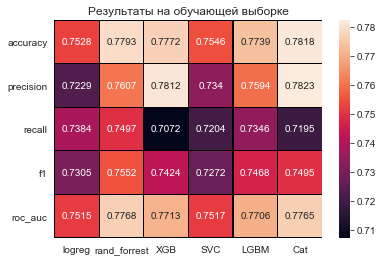

In [65]:
g = sns.heatmap(df_train_scores, annot = True, linewidths=0.1, linecolor = 'black', fmt='.4g',
                yticklabels = list(df_train_scores.index))
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
plt.title('Результаты на обучающей выборке')
plt.show()

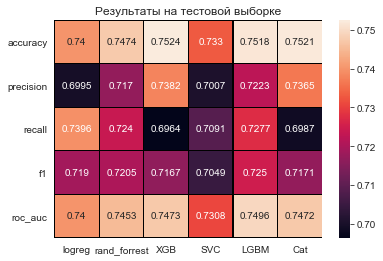

In [66]:
g = sns.heatmap(df_test_scores, annot = True, linewidths=0.1, linecolor = 'black', fmt='.4g',
                yticklabels = list(df_test_scores.index))
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
plt.title('Результаты на тестовой выборке')
plt.show()

## В качестве метрики для выбора модели следует брать ROC_AUC, т.к. она лучше всех характеризует качество модели. Все остальные метрики зависят от выбранного порога.   Лучшие результаты на обучающей выборке показал randomforrest.  Соответственно выбираем его для прогнозирования вероятностей.
ТАкже построим для него roc_auc_curve, prc_curve, и посмотрим на важность признаков

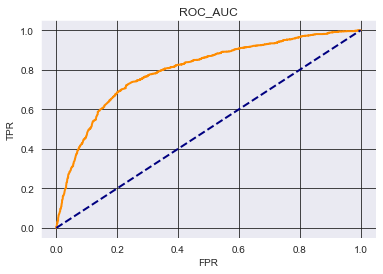

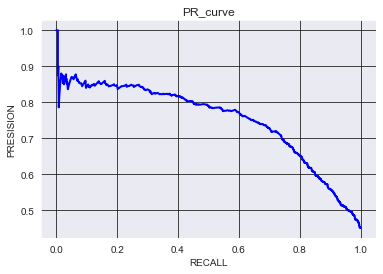

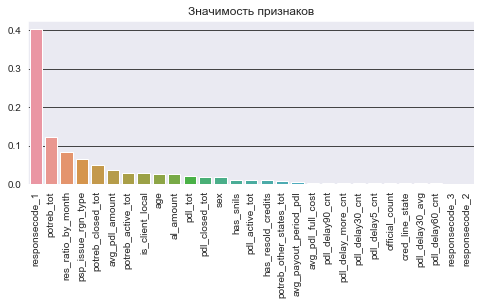

In [67]:
roc_auc_curve(y_test, X_oho_st_test, model_rf)
prc_curve(y_test, X_oho_st_test, model_rf)
importance_visualisation(model_rf, X_oho_st_test.columns)

По диаграмме важности признаков видим, что на 3 и 4 месте по важности находятся признаки res_ratio_by_month и psp_issue_rgn_type, которые мы создали самостоятельно

## 6. Вычисляем вероятности

In [68]:
X_oho_st = pd.concat([X_oho_st_train, X_oho_st_test])

In [69]:
pred_proba = model_rf.predict_proba(X_oho_st)[:,1]
pred_proba

array([0.28198787, 0.52743697, 0.19464516, ..., 0.74616219, 0.54437501,
       0.56696909])

In [72]:
pd.DataFrame({'is_test' : df['is_test'],
              'predicted_probability' : pred_proba}).to_excel('pred_proba.xlsx')